In [1]:
import time
import pandas as pd
import talib as t
import pandas_ta as ta
from tqdm import tqdm
from untrade.client import Client
from pprint import pprint
import matplotlib.pyplot as plt
import warnings
from pykalman import KalmanFilter
import numpy as np
from datetime import datetime,timedelta
import yfinance as yf
import requests
from arch import arch_model
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')


37800it [09:22, 67.15it/s] 


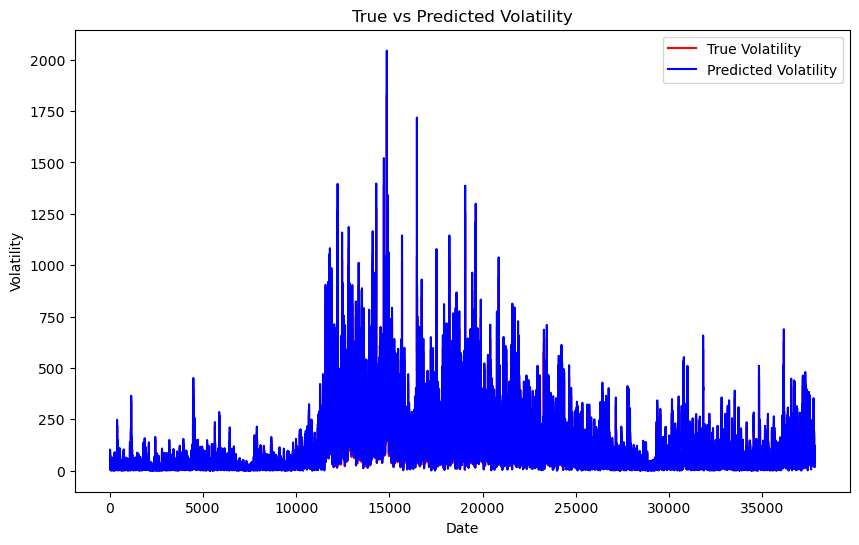

100%|██████████| 37773/37773 [00:28<00:00, 1338.53it/s]


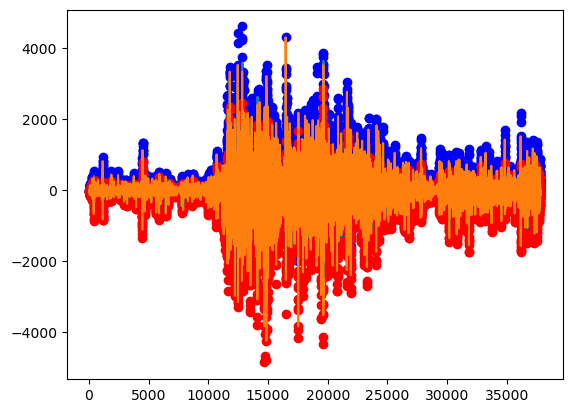

100%|██████████| 214/214 [00:00<00:00, 1273.11it/s]


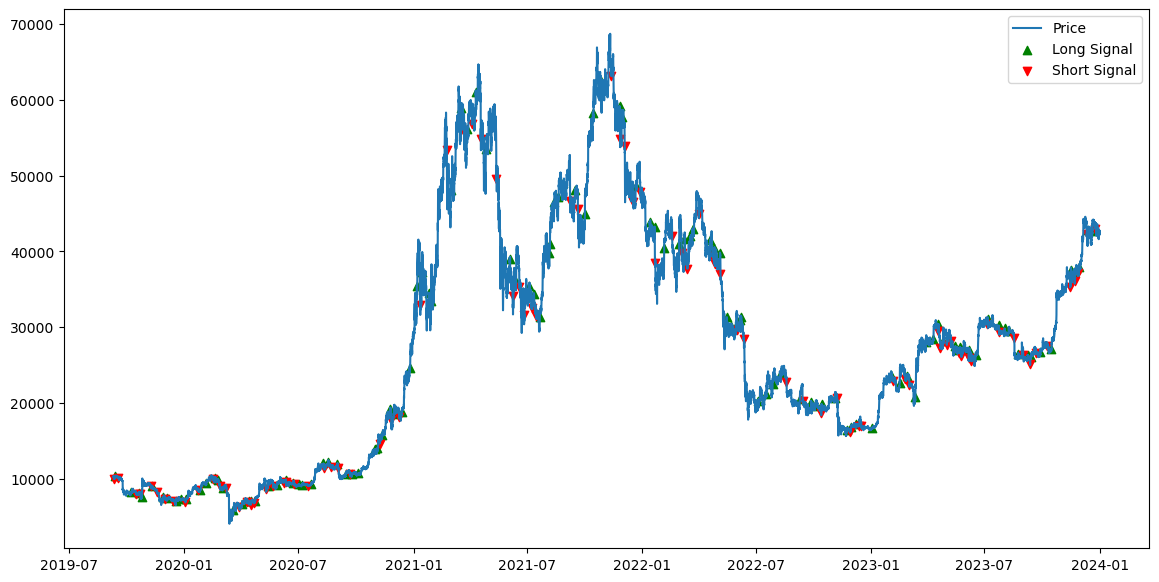

winrate is  0.40930232558139534
pnl : 3003.407989191722
n_trades: 215
Max_dd_s: 12.549011023953307
Max_dd_comp 36.36222340988214
Max_dd_trade 141


In [33]:
class PnlCalculator:
    def __init__(self, ema_fast, ema_slow, exit_threshold, ema_fastest,look_back_days,garch_window,vol_index_look_back_days,adx_threshold,slope_window):
        self.ema_fast = ema_fast
        self.ema_slow = ema_slow
        self.ema_fastest = ema_fastest
        self.vol_index_look_back_days = vol_index_look_back_days
        self.adx_threshold = adx_threshold
        self.exit_threshold = exit_threshold
        self.look_back_days = look_back_days
        self.stop_loss_percent = 5
        self.garch_window=garch_window
        self.slope_window=slope_window
    def kalman(self,data:pd.Series):
        kf = KalmanFilter(
            transition_matrices=[1],
            observation_matrices=[1],
            initial_state_mean=0,
            initial_state_covariance=1,
            observation_covariance=1,
            transition_covariance=0.1
        )

        filtered_state_means, _ = kf.filter(data.values)
        data=filtered_state_means
        return data
    def predict_volatility(self,data):
        garch_model = arch_model(data, p=1, q=1, vol='Garch')
        model_fit = garch_model.fit(disp='off')
        forecast = model_fit.forecast(horizon=1)
        prediction = np.sqrt(forecast.variance.iloc[-1, 0])
        return prediction
        
    def evaluate(self,df):
        
        tqdm.pandas()
        df['predictions'] = df['diff'].rolling(self.garch_window).progress_apply(lambda x: self.predict_volatility(x))*1.25
        df['True_vol']=df['diff'].rolling(self.garch_window).std()
       
        plt.figure(figsize=(10,6))
        plt.plot(df['True_vol'], color='red', label='True Volatility')
        plt.plot(df['predictions'], color='blue', label='Predicted Volatility')
        plt.title('True vs Predicted Volatility')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.legend()
        plt.show()
        return df
    def calc(self,data, window, target_var):
        # Calculate the mean with the new `x`
        copy=data
        mean =data.sum()
        mean /= window
        temp=data.iloc[-1]
        data=mean-data
        a=window+(window-1)**2
        b=2*(data.sum())-2*mean*(window-1)
        
        c=(data**2).sum()-target_var+(mean**2)
        D=b*b-4*a*c
        r1=window*(-b+np.sqrt(D))/(2*a)
        r2=window*(-b-np.sqrt(D))/(2*a)
        # if D<0:
        #     r1,r2=calc(copy,window,target_var-(D/(4*a)))
        # print(a,b,c)
        # if D<0:
        #     return temp
        # if r1*r2>0:
        #     return r1
        # elif temp<mean and r1<mean:
        #     return r1
        # else:
        #     return r2
        return r1,r2

    def ema(self, series, length):
        return series.ewm(span=length, adjust=False).mean()
    def zlag_t3(self, src, length):
        """
        Calculates a T3-like smoothing of the input source using multiple EMA calculations.
        
        Parameters:
            src (pd.Series): The source data (e.g., prices).
            length (int): The smoothing length.
    
        Returns:
            pd.Series: The smoothed T3-like values.
        """
        ema1 = self.ema(src, length)
        ema2 = self.ema(ema1, length)
        ema3 = self.ema(ema2, length)
        out = 2.5 * (ema1 - ema2) + ema3
        ema1a = self.ema(out, length)
        ema2a = self.ema(ema1a, length)
        ema3a = self.ema(ema2a, length)
        outf = 3.5 * (ema1a - ema2a) + ema3a
        return outf
    def calculate_slope(self,window):
        x = np.array(range(len(window)))  # Time indices within the window
        y = window.values  # Time series values in the window
        slope, intercept, _, _, _ = linregress(x, y)  # Perform linear regression
        return slope    

    
    def pred_plot(self,df):
        plt.plot(df.index, df['diff'], label='diff',color='black')

        # Scatter plots for shifted 'diff_next_1' and 'diff_next_2'
        plt.scatter(df.index, df['diff_next_1'].shift(), color='blue', label='diff_next_1 shifted')
        plt.scatter(df.index, df['diff_next_2'].shift(), color='red', label='diff_next_2 shifted')

        # Adding labels and showing the plot
        # plt.xlabel('Index')
        # plt.ylabel('Values')
        # plt.legend()
        # plt.show()
    def Crossover(self):
        #importing and processing bitcoin data
        start_time = time.time()
        
        df = pd.read_csv("BTC_2019_2023_1h.csv")
        # df=df[:500]
        df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
        df["datetime"] = pd.to_datetime(df["datetime"])
        df["t3"]=self.zlag_t3(df["HA_Close"], 25)
        df["SMA"]=ta.sma(df["HA_Close"], length=4)
        df["RSI"]=ta.rsi(df["HA_Close"], length=30)
  
 



        df['diff']=df['SMA']-df['t3']
        # df['returns']=(df['diff']).pct_change().dropna()*100
        # df = df.dropna(subset=['returns'])


        df=self.evaluate(df)
        df=df.dropna()
        df['predictions'] = (df['predictions'] ** 2) * (self.garch_window-1)
        df['diff_next_1']=None
        df['diff_next_2']=None
        # results_df = pd.DataFrame()
        # Loop through each rolling window and apply minimization
        for i in tqdm(range(self.garch_window - 2, len(df)-1)):
            # Select the rolling window data
            data_window = df['diff'].iloc[i - self.garch_window + 2:i + 1]  # Adjust window selection as needed
            
            # Define a wrapper function for the optimizer to minimize `calc()` over `x`
            df['diff_next_1'].iloc[i],df['diff_next_2'].iloc[i]=self.calc(data_window, self.garch_window,df['predictions'].iloc[i+1])

        self.pred_plot(df)
        
        df['slope'] = df['diff'].rolling(window=self.slope_window).apply(self.calculate_slope, raw=False)
        df['diff_next'] = np.where(df['slope'] > 0, df['diff_next_1'], df['diff_next_2'])
        df['diff_next'] = df['diff_next'].fillna(method='ffill')
        plt.plot(df['diff'])
        plt.plot(df['diff_next'].shift())
        plt.show()
        # conditions = [
        # (df['sma_long'] > df['sma_short']) & (df['sma_long'].shift(1) < df['sma_short'].shift(1)),  # Condition for -1
        # (df['sma_long'] < df['sma_short']) & (df['sma_long'].shift(1) > df['sma_short'].shift(1)),  # Condition for 1
        # ]
        # values = [2, 1]  
        # df['act_cross'] = np.select(conditions, values, default=0)
        _conditions = [
                (df['diff']<0 ) & (df['diff_next']>0),  # Condition for 1
                (df['diff']>0 ) & (df['diff_next']<0),  # Condition for -1
                ]
        values = [2, 1]  
        df['pred_cross'] = np.select(_conditions, values, default=0)
        # df['act_cross'] = df['act_cross'].replace(0, np.nan).ffill().fillna(0).astype(int)
        df['pred_cross'] = df['pred_cross'].replace(0, np.nan).ffill().fillna(0).astype(int)
        df.drop(columns=['diff_next_1', 'diff_next_2'], inplace=True)
        df.to_csv('data.csv')

  
        df['HA_Open'] = (df['open'] + df['close']) / 2
        df['HA_Open'] = df['HA_Open'].shift(1)
        df['HA_Open'].iloc[0] = df['open'].iloc[0]
        df['HA_High'] = df[['HA_Open', 'HA_Close']].join(df['high']).max(axis=1)
        df['HA_Low'] = df[['HA_Open', 'HA_Close']].join(df['low']).min(axis=1)

        df['ATR'] = ta.atr(df.HA_High, df.HA_Low, df.HA_Close, window=14)
        df['adx'] = t.ADX(df['HA_High'], df['HA_Low'], df['HA_Close'], timeperiod=self.look_back_days)
        df['+di'] = t.PLUS_DI(df['HA_High'], df['HA_Low'], df['HA_Close'], timeperiod=15)
        df['-di'] = t.MINUS_DI(df['HA_High'], df['HA_Low'], df['HA_Close'], timeperiod=15)
        df['RSI'] = t.RSI(df['HA_Close'], timeperiod=14)
        #generating core signals
        # df['bb_up']=df['HA_Close'].rolling(20).mean()+2*df['HA_Close'].rolling(20).std()
        # df['bb_down']=df['HA_Close'].rolling(20).mean()-2*df['HA_Close'].rolling(20).std()

        # df['Signal_Long']=(((df['pred_cross']==1)&(df['act_cross']!=2))|(df['act_cross']==1))&((df['adx'] < self.adx_threshold)&(df['previous_sar']<df['HA_Close']))
        # df['Signal_Short']=(((df['pred_cross']==2)&(df['act_cross']!=1))|(df['act_cross']==2))&(df['adx'] < self.adx_threshold)&(df['previous_sar']>df['HA_Close'])

        # df['signals'] = np.where(df['Signal_Long'], 1, np.where(df['Signal_Short'], 2, 0))
        # df['signals'] = df.apply(lambda row: row['signals'] if row['rsi'] < 90 else 0, axis=1)

        

        df["signal"] = 0
        position = None
        entry_price = None
        #last_date = df2["datetime"][0]

        for i in tqdm(range(1, len(df))):
            # Replace curr_row with df.iloc[i]
            # Long entry condition
            if (df.iloc[i]["RSI"] >= 75) and ((df['diff_next'].iloc[i]>0.0)or(df['diff'].iloc[i]>0.0) ) and (position is None):
                position = "long"
                entry_price = df.iloc[i]["close"]
                stop_loss_price = entry_price * (1 - self.stop_loss_percent / 100)
                df.loc[df["datetime"] == df.iloc[i]["datetime"], "signal"] = 1
                df.loc[df["datetime"] == df.iloc[i]["datetime"], "trade_type"] = 'long'

            # Short entry condition
            if (df.iloc[i]["RSI"] <= 20) and ((df['diff_next'].iloc[i] <0.0 )or(df['diff'].iloc[i]<0.0)) and (position is None):
                position = "short"
                entry_price = df.iloc[i]["close"]
                stop_loss_price = entry_price * (1 + self.stop_loss_percent / 100)
                df.loc[df["datetime"] == df.iloc[i]["datetime"], "signal"] = 2
                df.loc[df["datetime"] == df.iloc[i]["datetime"], "trade_type"] = 'short'

            # Long exit condition
            if position == "long":
                if (df.iloc[i]["RSI"] <= 25) and ((df['diff_next'].iloc[i] <0.0)or(df['diff'].iloc[i]<0.0) ) or (df.iloc[i]["close"] <= stop_loss_price):
                    position = None
                    stop_loss_price = df.iloc[i]["close"] * (1 - self.stop_loss_percent / 100)
                    df.loc[df["datetime"] == df.iloc[i]["datetime"], "signal"] = -1
                    df.loc[df["datetime"] == df.iloc[i]["datetime"], "trade_type"] = 'square-off'

            # Short exit condition
            if position == "short":
                if (df.iloc[i]["RSI"] >= 75) and ((df['diff_next'].iloc[i] >0.0)or(df['diff'].iloc[i])>0.0) or (df.iloc[i]["close"] >= stop_loss_price):
                    position = None
                    stop_loss_price = df.iloc[i]["close"] * (1 + self.stop_loss_percent / 100)
                    df.loc[df["datetime"] == df.iloc[i]["datetime"], "signal"] = -2
                    df.loc[df["datetime"] == df.iloc[i]["datetime"], "trade_type"] = 'square-off'

        # Force close any remaining open positions at the end of the data
        if position == "long":
            final_price = df.iloc[-1]['close']
            final_time = df.iloc[-1]['datetime']
            df.loc[df['datetime'] == final_time, 'signal'] = -1
            df.loc[df['datetime'] == final_time, 'trade_type'] = 'square-off'
        elif position == "short":
            final_price = df.iloc[-1]['close']
            final_time = df.iloc[-1]['datetime']
            df.loc[df['datetime'] == final_time, 'signal'] = -2
            df.loc[df['datetime'] == final_time, 'trade_type'] = 'square-off'

   
        #Removing potential duplicate signals
        df_1 = df
        """
        long_open = False
        short_open = False

        for index, row in df_1.iterrows():
            signal = row['signal']

            if signal == 2 and short_open:
                df_1.at[index, 'signal'] = 0
            elif signal == 1 and long_open:
                df_1.at[index, 'signal'] = 0
            elif signal == 1 and long_open != True:
                long_open = True
            elif signal == 2 and short_open != True:
                short_open = True

            elif signal == -1:
                if long_open:
                    long_open = False
                else:
                    df_1.at[index, 'signal'] = 0
            elif signal == -2:
                if short_open:
                    short_open = False
                else:
                    df_1.at[index, 'signal'] = 0
        """
        df_1['signals']=df_1['signal']
        df_1.to_csv('signals.csv')
        dg = df_1[df_1['signal'] != 0]
        df_2 = dg
        df_2['signal_filtered'] = dg['signal']
        df_2.to_csv('signals_filtered.csv')
        

        #Calculating performance metrics
        dg['entry_price'] = dg['close']
        dg['entry_timestamp'] = dg['datetime']
        dg['exit_price'] = dg['entry_price'].shift(-1)
        dg['exit_timestamp'] = dg['datetime'].shift(-1)
        pnl = dg[dg['signal'] > 0][['entry_timestamp', 'entry_price', 'exit_timestamp', 'exit_price', 'signal','trade_type']]

        pnl['profit_per_btc'] = np.where(pnl['signal'] == 1, pnl['exit_price'] - pnl['entry_price'], 
                                        np.where(pnl['signal'] == 2, pnl['entry_price'] - pnl['exit_price'], None)) 
        pnl['capital'] = 1000
        pnl['#units'] = pnl['capital'] / pnl['entry_price']
        pnl['profit_per_capital'] = pnl['#units'] * pnl['profit_per_btc']
        pnl['tnc_cost'] = 1
        pnl['profit_after_tnc'] = pnl['profit_per_capital'] - pnl['tnc_cost']
        pnl['cumulative_profit'] = pnl['profit_after_tnc'].cumsum()
        pnl['roe_%'] = (pnl['profit_after_tnc'] / pnl['capital']) * 100
        net_pnl = pnl.reset_index()
        n_trades = pnl.shape[0]
        pnl['c_f'] = pnl['cumulative_profit'] + 1000
        peak = 1000
        max_drawdown = 0
        for value in pnl['c_f']:
            if value > peak:
                peak = value
            drawdown = (peak - value) / peak
            if drawdown > max_drawdown:
                max_drawdown = drawdown

        max_drawdown_percentage_static = max_drawdown * 100

        d = dg[dg['signal'] > 0][['entry_timestamp', 'entry_price', 'exit_timestamp', 'exit_price', 'signal','trade_type']]
        d['profit_per_eth'] = np.where(d['signal'] == 1, d['exit_price'] - d['entry_price'], 
                                                 np.where(d['signal'] == 2, d['entry_price'] - d['exit_price'], None))
        d['tnc_cost'] = 1
        d['capital'] = 1000
        d['units'] = 1000 / d['entry_price']
        d['profit_per_capital'] = d['units'] * d['profit_per_eth']
        d['profit_after_tnc'] = d['profit_per_capital'] - d['tnc_cost']
       
        
        for i in tqdm(range(1, len(d))):
            d['capital'].iloc[i] = d['capital'].iloc[i - 1] + d['profit_after_tnc'].iloc[i - 1]
            d['units'].iloc[i] = d['capital'].iloc[i] / d['entry_price'].iloc[i]
            d['profit_per_capital'].iloc[i] = d['units'].iloc[i] * d['profit_per_eth'].iloc[i]
            d['profit_after_tnc'].iloc[i] = d['profit_per_capital'].iloc[i] - d['tnc_cost'].iloc[i]
            

        d['c_f'] = d['capital']
        peak = 1000
        max_drawdown = 0
        max_dd_trade_time = 0
        max_dd_index = 0 

        for i, value in enumerate(d['c_f']):
            if value > peak:
                peak = value
            drawdown = (peak - value) / peak
            if drawdown > max_drawdown:
                max_drawdown = drawdown
                max_dd_index = i

        max_drawdown_percentage_compounding = max_drawdown * 100

        end_time = time.time()
        time_taken = end_time - start_time
        # change non numeric values in close to nan and then drop the nan values to avoid errors
        df['close'] = pd.to_numeric(df['close'], errors='coerce')
        
        df = df.dropna(subset=['close'])
        #plotting signals v/s price 
        # df['datetime'] = pd.to_datetime(df['datetime'])
        plt.figure(figsize=(14, 7))
        plt.plot(df['datetime'],df['close'], label='Price')
        plt.scatter(df[df['signal'] == 1]['datetime'], df[df['signal'] == 1]['close'], marker='^', color='g', label='Long Signal', alpha=1)
        plt.scatter(df[df['signal'] == 2]['datetime'], df[df['signal'] == 2]['close'], marker='v', color='r', label='Short Signal', alpha=1)
        plt.legend()
        plt.show()
        win_rate=len(d[d['profit_after_tnc']>0])/len(d['profit_after_tnc'])
        print('winrate is ', win_rate)
        return win_rate, net_pnl, net_pnl['profit_after_tnc'].sum(), time_taken, max_drawdown_percentage_static, n_trades, max_drawdown_percentage_compounding, max_dd_index,d  




if __name__ == "__main__":
    pnl_calculator = PnlCalculator(
        ema_fast=20, 
        ema_slow=50, 
        ema_fastest=5, 
        vol_index_look_back_days=20,
        adx_threshold = 25 ,
        exit_threshold =70,
        look_back_days = 14,
        garch_window=6,
        slope_window=5)  # Create an instance of PnlCalculator 
    win_rate, obj, net_pnl_amount, time_taken, max_drawdown_percentage_static, n_trades, max_drawdown_percentage_compounding, max_dd_index, d = pnl_calculator.Crossover()

    obj.to_csv('pnl_since_2019.csv', index=False)
    
    print("pnl :", net_pnl_amount)
    print("n_trades:", n_trades)
    print("Max_dd_s:", max_drawdown_percentage_static)
    print("Max_dd_comp", max_drawdown_percentage_compounding)
    print("Max_dd_trade", max_dd_index)


In [34]:
def strat(data):
    dg = data
    for i in tqdm(range(len(dg))):
        if dg['signals'].iloc[i] == 2 :
            dg['signals'].iloc[i] = -1
        elif dg['signals'].iloc[i] == -2 :
            dg['signals'].iloc[i] = 1
    return dg

In [35]:
def perform_backtest(csv_file_path):
    client = Client()

    # Perform backtest using the provided CSV file path
    result = client.backtest(
        jupyter_id="kchitizraj",  # the one you use to login to jupyter.untrade.io
        file_path=csv_file_path,
        leverage=1,# Adjust leverage as needed
    )
    return result

In [36]:
import pandas as pd

if __name__ == "__main__":
    # Read data from CSV file
    data = pd.read_csv("signals.csv")
    data = data.dropna()

    # Add missing 'trade_type' column with default value (e.g., '0')
    if 'trade_type' not in data.columns:
        data['trade_type'] = 0  # You can also set None or any other default value

    # Filter out rows where "signals" is 0
    data = data[data["signals"] != 0]

    # Rename 'timestamp' to 'datetime'
    data = data.rename(columns={'timestamp': 'datetime'})

    # Process the data
    res1 = strat(data)
    res = res1
    res.to_csv("processed_data.csv", index=False)

    # Perform backtest on processed data
    csv_file_path = "processed_data.csv"
    backtest_result = perform_backtest(csv_file_path)

    # Get the last value of backtest result
    last_value = None
    for value in backtest_result:
        print(value)  # Uncomment to see the full backtest result (backtest_result is a generator object)
        last_value = value
    # print(last_value)

100%|██████████| 429/429 [00:00<00:00, 6629.73it/s]


data: {
  "jupyter_id": "kchitizraj",
  "result_type": "Main",
  "message": "Backtest completed",
  "result": {
    "static_statistics": {
      "From": "2019-09-12 14:00:00",
      "Total Trades": 214,
      "Leverage Applied": 1.0,
      "Winning Trades": 85,
      "Losing Trades": 129,
      "No. of Long Trades": 126,
      "No. of Short Trades": 88,
      "Benchmark Return(%)": 312.452317,
      "Benchmark Return(on $1000)": 3124.523172,
      "Win Rate": 39.719626,
      "Winning Streak": 4,
      "Losing Streak": 9,
      "Gross Profit": 3248.236588,
      "Net Profit": 2927.236588,
      "Average Profit": 13.678676,
      "Maximum Drawdown(%)": 13.091954,
      "Average Drawdown(%)": 4.182215,
      "Largest Win": 557.797221,
      "Average Win": 89.007051,
      "Largest Loss": -80.786283,
      "Average Loss": -35.9563,
      "Maximum Holding Time": "29 days 21:0:0",
      "Average Holding Time": "6 days 3:58:52",
      "Maximum Adverse Excursion": 10.839489,
      "Average Ad